(-9.993260931968688, 7.225806307792664, -3.697633481025696, 3.717580533027649)

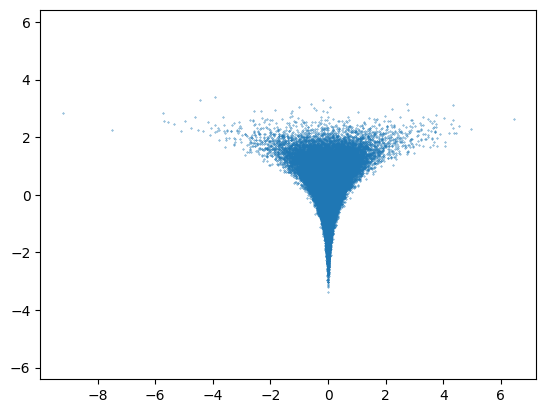

In [60]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_swiss_roll

def sample_funnel_data(num_samples=10000):
    """
    从简化 2D funnel 分布中采样:
    z ~ N(0, 1)
    x ~ N(0, exp(z))
    返回 shape: (num_samples, 2)
    """
    z = torch.randn(num_samples)*0.8
    x = torch.randn(num_samples) * torch.exp(z )/5  # exp(z/2) 的方差 = exp(z)
    data = torch.stack([x,z], dim=1)  # shape [num_samples, 2]
    return data


# x, _ = make_swiss_roll(n_samples=100000, noise=0.5)
x = sample_funnel_data(num_samples=100000)
# Make two-dimensional to easen visualization
# x = x[:, [0, 2]]

# x = (x - x.mean()) / x.std()
# x = torch.clamp(x, min=-6,max=6)
plt.scatter(x[:, 0], x[:, 1],s=0.1)
plt.axis("equal")

In [61]:
x.shape

torch.Size([100000, 2])

/tmp/ipykernel_659615/1588486638.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(x, dtype=torch.float32)


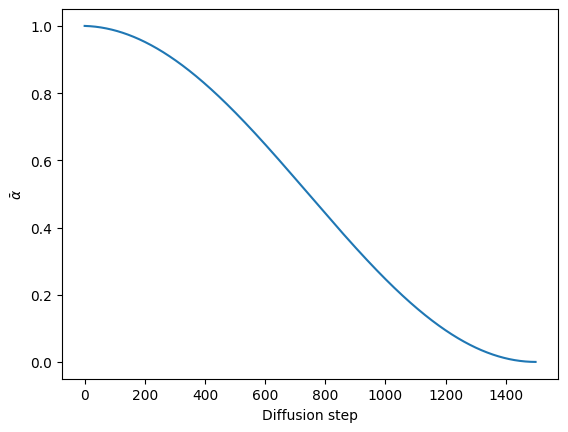

In [62]:
import torch

X = torch.tensor(x, dtype=torch.float32)
diffusion_steps = 1500  # Number of steps in the diffusion process

# Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

# Check the cumulative alphas follow the distribution recommended in the paper
sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

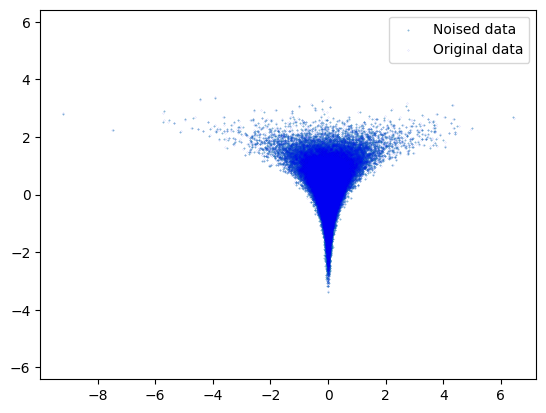

In [65]:
def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)
    noised = (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps
noiselevel = 20

noised, eps = noise(X, torch.full([len(X), 1], fill_value=noiselevel))
plt.scatter(noised[:, 0], noised[:, 1], marker="*", alpha=0.5,s=0.1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5,s=0.01,c='blue')
plt.legend(["Noised data", "Original data"])
plt.axis("equal") 
plt.show()

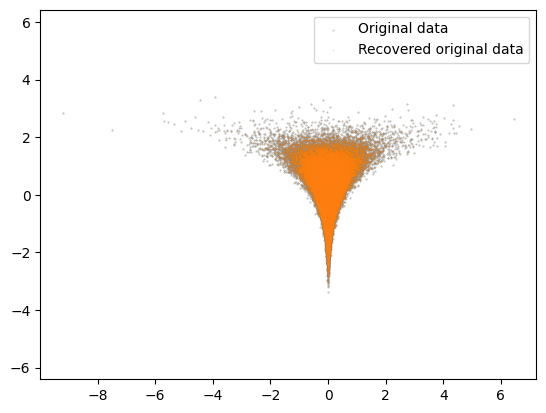

In [66]:
denoised = 1 / torch.sqrt(baralphas[noiselevel]) * (noised - torch.sqrt(1 - baralphas[noiselevel]) * eps)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5,s=0.1)
plt.scatter(denoised[:, 0], denoised[:, 1], marker="1", alpha=0.5,s=0.1)
plt.legend(["Original data", "Recovered original data"])
plt.axis("equal") 
plt.show()

In [67]:
import torch.nn as nn

class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val


In [68]:
model = DiffusionModel(nfeatures=2, nblocks=4)

device = "cuda"
model = model.to(device)

model

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-3): 4 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

In [69]:
import torch.optim as optim

nepochs = 100
batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

for epoch in range(nepochs):
    epoch_loss = steps = 0
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise(Xbatch, timesteps)
        predicted_noise = model(noised.to(device), timesteps.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 1.3716886043548584
Epoch 1 loss = 0.9959409832954407
Epoch 2 loss = 0.9881517887115479
Epoch 3 loss = 0.9812204837799072
Epoch 4 loss = 0.9744710922241211
Epoch 5 loss = 0.95766282081604
Epoch 6 loss = 0.9439486265182495
Epoch 7 loss = 0.9397062659263611
Epoch 8 loss = 0.8811715245246887
Epoch 9 loss = 0.9479353427886963
Epoch 10 loss = 0.8646755218505859
Epoch 11 loss = 0.8391110897064209
Epoch 12 loss = 0.8922882676124573
Epoch 13 loss = 0.7881991267204285
Epoch 14 loss = 0.8974890112876892
Epoch 15 loss = 0.9668299555778503
Epoch 16 loss = 0.6761483550071716
Epoch 17 loss = 0.6808778047561646
Epoch 18 loss = 0.5127907395362854
Epoch 19 loss = 0.4747890830039978
Epoch 20 loss = 0.5297287702560425
Epoch 21 loss = 0.7315043807029724
Epoch 22 loss = 0.4922294020652771
Epoch 23 loss = 0.4431648254394531
Epoch 24 loss = 0.47410348057746887
Epoch 25 loss = 0.3819446861743927
Epoch 26 loss = 0.3786526918411255
Epoch 27 loss = 0.37339848279953003
Epoch 28 loss = 0.387114197015

In [70]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt

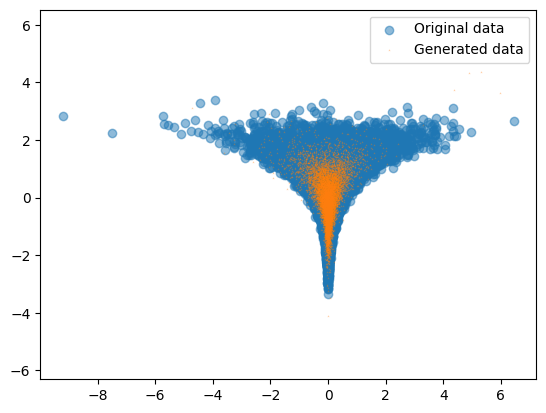

In [71]:
Xgen, Xgen_hist = sample_ddpm(model, 10000, 2)
Xgen = Xgen.cpu()
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="1", alpha=0.5,s=0.1)
plt.legend(["Original data", "Generated data"])
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.axis("equal") 
plt.show()

In [75]:
from matplotlib.animation import FuncAnimation, PillowWriter

def make_animation(trajectory, filename="sampling.gif"):
    """
    Given a list of [N x 2] arrays (trajectory), create and save an animation.
    """
    trajectory = [x.cpu() for x in trajectory]
    fig, ax = plt.subplots(figsize=(5, 5))
    scat = ax.scatter(trajectory[0][:, 0], trajectory[0][:, 1], alpha=0.5, color='red',s=0.2)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.axis("off")
    ax.set_aspect('equal')
    time_text = ax.text(0.02, 0.02, '', transform=ax.transAxes, fontsize=12)

    def update(frame):
        data = trajectory[frame]
        scat.set_offsets(data)
        time_text.set_text(f"Step {frame}/{len(trajectory)-1}")
        return scat, time_text

    ani = FuncAnimation(fig, update, frames=len(trajectory), interval=1)
    writer = PillowWriter(fps=40)
    ani.save(filename, writer=writer)
    plt.close()

In [76]:
make_animation(Xgen_hist, filename="ddpm_sde.gif")

# discrete DDPM

In [82]:
from matplotlib.animation import FuncAnimation, PillowWriter

def make_animation(trajectory, filename="sampling.gif"):
    """
    Given a list of [N x 2] arrays (trajectory), create and save an animation.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    scat = ax.scatter(trajectory[0][:, 0], trajectory[0][:, 1], alpha=0.5, color='red',s=0.2)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.axis("off")
    ax.set_aspect('equal')
    time_text = ax.text(0.02, 0.02, '', transform=ax.transAxes, fontsize=12)

    def update(frame):
        data = trajectory[frame]
        scat.set_offsets(data)
        time_text.set_text(f"Step {frame}/{len(trajectory)-1}")
        return scat, time_text

    ani = FuncAnimation(fig, update, frames=len(trajectory), interval=1)
    writer = PillowWriter(fps=40)
    ani.save(filename, writer=writer)
    plt.close()

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Function to generate funnel data
def sample_funnel_data(num_samples=10000):
    z = torch.randn(num_samples) * 0.8
    x = torch.randn(num_samples) * torch.exp(z) / 5
    return torch.stack([x, z], dim=1)

class ScoreModel(nn.Module):
    def __init__(self, hidden_dims=[128, 256, 128], embed_dim=64):
        super().__init__()
        # 时间嵌入层
        self.embed = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        # 主干网络
        self.net = nn.ModuleList()
        input_dim = 2  # 输入维度
        for h_dim in hidden_dims:
            self.net.append(nn.Sequential(
                nn.Linear(input_dim + embed_dim, h_dim),
                nn.SiLU()))
            input_dim = h_dim
        self.out = nn.Linear(input_dim, 2)  # 输出噪声预测
    
    def forward(self, x, t):
        t_embed = self.embed(t)
        for layer in self.net:
            x = layer(torch.cat([x, t_embed], dim=1))
        return self.out(x)

# 训练参数
beta_min, beta_max = 0.1, 20.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device ='cpu'
model = ScoreModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# 准备数据
data = sample_funnel_data(100000)
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)


from tqdm import tqdm
# 训练循环
for epoch in tqdm(range(1000)):
    total_loss = 0.0
    for batch, in dataloader:
        x0 = batch.to(device)
        batch_size = x0.size(0)
        
        # 采样时间和噪声
        t = torch.rand(batch_size, 1, device=device)
        epsilon = torch.randn_like(x0, device=device)
        
        # 计算 α(t) 和 σ(t)
        integral = beta_min * t + 0.5 * (beta_max - beta_min) * t**2
        alpha = torch.exp(-0.5 * integral)
        sigma = torch.sqrt(1.0 - alpha**2)
        
        # 扰动数据
        x_t = alpha * x0 + sigma * epsilon
        
        # 预测噪声
        epsilon_pred = model(x_t, t)
        
        # 计算加权损失
        beta_t = beta_min + (beta_max - beta_min) * t
        loss = torch.mean(beta_t * (epsilon_pred - epsilon)**2)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(data):.5f}")

 10%|████████████████████▏                                                                                                                                                                                     | 100/1000 [00:46<06:53,  2.18it/s]

Epoch 100, Loss: 0.52127


 20%|████████████████████████████████████████▍                                                                                                                                                                 | 200/1000 [01:32<05:55,  2.25it/s]

Epoch 200, Loss: 0.52264


 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 300/1000 [02:18<06:15,  1.86it/s]

Epoch 300, Loss: 0.51823


 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 400/1000 [03:07<04:37,  2.16it/s]

Epoch 400, Loss: 0.52124


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 500/1000 [03:53<03:43,  2.24it/s]

Epoch 500, Loss: 0.51495


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 600/1000 [04:38<02:51,  2.33it/s]

Epoch 600, Loss: 0.51079


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 700/1000 [05:23<02:10,  2.30it/s]

Epoch 700, Loss: 0.51898


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 800/1000 [06:10<01:25,  2.34it/s]

Epoch 800, Loss: 0.51332


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 900/1000 [06:58<00:47,  2.11it/s]

Epoch 900, Loss: 0.52622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:48<00:00,  2.13it/s]

Epoch 1000, Loss: 0.52061


In [91]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def vp_sde_sample(x_T, timesteps, beta_min=0.1, beta_max=20.0, save_trajectory=True):
    """
    Implements the reverse sampling process for VP-SDE using Euler-Maruyama method.
    
    Args:
        x_T: Final noisy sample (torch.Tensor) of shape (N, D)
        timesteps: Number of diffusion steps (int)
        beta_min: Minimum beta value (float)
        beta_max: Maximum beta value (float)
        save_trajectory: Whether to save and return the sampling trajectory (bool)
    
    Returns:
        x_0: Recovered data sample (torch.Tensor)
        trajectory: List of intermediate states (if save_trajectory=True)
    """
    dt = 1.0 / timesteps  # Time step for numerical integration
    x_t = x_T.clone()
    trajectory = [x_t.clone().cpu().numpy()] if save_trajectory else None

    for t in reversed(range(timesteps)):
        time = t * dt
        beta_t = beta_min + time * (beta_max - beta_min)
        alpha_t = torch.exp(-0.5 * (beta_min * time + 0.5 * (beta_max - beta_min) * time**2))
        sigma_t = torch.sqrt(1 - alpha_t)

        # Reverse SDE Euler-Maruyama step
        x_t = x_t + 0.5 * beta_t * x_t * dt + beta_t * sigma_t * torch.randn_like(x_t) * torch.sqrt(dt)

        if save_trajectory:
            trajectory.append(x_t.clone().cpu().numpy())

    return x_t, trajectory if save_trajectory else None

# Set parameters
timesteps = 1000
num_samples = 10000
dim = 2  # 2D distribution for visualization
x_T = torch.randn(num_samples, dim)  # Sample from Gaussian prior (standard normal)

# Perform VP-SDE sampling
x_0, trajectory = vp_sde_sample(x_T, timesteps)

# Convert trajectory to numpy for plotting
trajectory_np = np.array(trajectory)  # Shape: (timesteps, num_samples, dim)

# Plot the evolution of the sampling process
plt.figure(figsize=(10, 5))
for i in range(0, timesteps, timesteps // 10):  # Plot 10 intermediate steps
    plt.scatter(trajectory_np[i, :, 0], trajectory_np[i, :, 1], alpha=0.3, label=f"Step {i}")

plt.scatter(x_0[:, 0].numpy(), x_0[:, 1].numpy(), color='red', alpha=0.7, label="Final Sampled Data")
plt.legend()
plt.title("VP-SDE Sampling Trajectory")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

# Plot final distribution shape
plt.figure(figsize=(6, 6))
plt.scatter(x_0[:, 0].numpy(), x_0[:, 1].numpy(), alpha=0.5, s=10)
plt.title("Final Sampled Distribution from VP-SDE")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()



TypeError: exp(): argument 'input' (position 1) must be Tensor, not float

In [83]:
make_animation(trajectory, filename="ddpm_sampling.gif")

# continuous version od DDPM

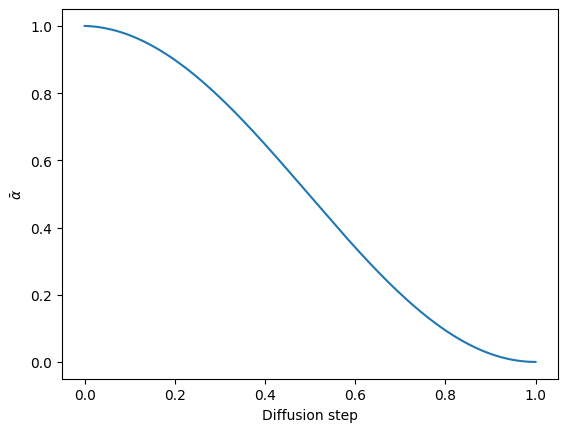

ValueError: only one element tensors can be converted to Python scalars

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate funnel data
def sample_funnel_data(num_samples=10000):
    z = torch.randn(num_samples) * 0.8
    x = torch.randn(num_samples) * torch.exp(z) / 5
    return torch.stack([x, z], dim=1)

# Generate dataset
X = sample_funnel_data(num_samples=100000).float()

diffusion_steps = 1500
s = 0.008
timesteps = torch.linspace(0, 1, steps=diffusion_steps, dtype=torch.float32)
schedule = torch.cos((timesteps + s) / (1 + s) * torch.pi / 2) ** 2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.cat([baralphas[0:1], baralphas[:-1]])
alphas = 1 - betas

# Visualization of schedule
sns.lineplot(x=timesteps, y=baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

# Define the stochastic differential equation (SDE)
def sde_drift(x, t):
    return -0.5 * betas[int(t * (diffusion_steps - 1))] * x

def sde_diffusion(t):
    return betas[int(t * (diffusion_steps - 1))] ** 0.5

# Define the reverse SDE for sampling
def reverse_sde(model, x, timesteps):
    dt = -1.0 / diffusion_steps
    trajectory = [x.cpu().numpy()]
    
    for t in torch.linspace(1, 0, steps=diffusion_steps, dtype=torch.float32):
        t_idx = int(t * (diffusion_steps - 1))
        z = torch.randn_like(x) if t > 0 else 0
        drift = sde_drift(x, t)
        diffusion = sde_diffusion(t)
        predicted_noise = model(x, t.view(-1, 1))
        x = x + drift * dt + diffusion * predicted_noise * (-dt).sqrt() + diffusion * z * (-dt).sqrt()
        trajectory.append(x.cpu().numpy())
    
    return x.cpu().numpy(), trajectory

# Define the diffusion model
class DiffusionModel(nn.Module):
    def __init__(self, nfeatures, nunits=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nfeatures + 1, nunits),
            nn.ReLU(),
            nn.Linear(nunits, nunits),
            nn.ReLU(),
            nn.Linear(nunits, nfeatures)
        )
    
    def forward(self, x, t):
        x = torch.cat([x, t], dim=1)
        return self.model(x)

# Initialize model
device = "cpu"
model = DiffusionModel(nfeatures=2).to(device)

# Training setup
nepochs = 100
batch_size = 2048
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(nepochs):
    epoch_loss, steps = 0, 0
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size].to(device)
        t = torch.rand((len(Xbatch), 1), device=device)
        noise = torch.randn_like(Xbatch)
        noised = Xbatch + sde_diffusion(t) * noise
        predicted_noise = model(noised, t)
        loss = loss_fn(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        steps += 1
    print(f"Epoch {epoch+1}/{nepochs}, Loss: {epoch_loss / steps:.6f}")

# Generate and visualize samples
x_init = torch.randn(100000, 2).to(device)
samples, trajectory = reverse_sde(model, x_init, timesteps)
plt.scatter(samples[:, 0], samples[:, 1], s=0.5, alpha=0.6)
plt.axis("equal")
plt.title("Generated Samples via Reverse SDE")
plt.show()
